# Jupiter's Notebook for Scenario 01
Requieres: [CategoryEncoders](http://contrib.scikit-learn.org/category_encoders/), and [imbalanced-learn](https://imbalanced-learn.org/stable/)<br>
`pip install category_encoders`<br>
`pip install xgboost`<br>
`pip install imbalanced-learn`

In [1]:
#import libraries
import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline,make_pipeline
from sklearn.feature_selection import SelectKBest,chi2
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from collections import Counter
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.calibration import CalibratedClassifierCV

In [2]:
#To identify class 0 and 1, respectively
target_names = ['class 0', 'class 1']

In [3]:
#load dataset
df=pd.read_csv('esc-01-Mixed-traffic.csv')

In [4]:
#check dataset dimensions
df.shape

(310663, 52)

## Pre-feature selection

In [5]:
#check the number of null values
print(df.isnull().sum())
print(df.isnull().values.sum())

proto                 0
ts                    0
srcIP                 0
srcPrt                0
dstIP                 0
dstPrt                0
flowduration          0
total_fpackets        0
total_bpackets        0
total_fpktl           0
total_bpktl           0
min_fpktl             0
min_bpktl             0
max_fpktl             0
max_bpktl             0
mean_fpktl            0
mean_bpktl            0
std_fpktl             0
std_bpktl             0
total_fipt            0
total_bipt            0
min_fipt              0
min_bipt              0
max_fipt              0
max_bipt              0
mean_fipt             0
mean_bipt             0
std_fipt              0
std_bipt              0
fpsh_cnt              0
bpsh_cnt              0
furg_cnt              0
burg_cnt              0
total_fhlen           0
total_bhlen           0
fPktsPerSecond        0
bPktsPerSecond        0
flowPktsPerSecond     0
flowBytesPerSecond    0
mean_flowpktl         0
std_flowpktl          0
mean_flowipt    

In [6]:
#Dropping Rows with NA inplace
df.dropna(inplace=True)

In [7]:
#sumarize the number of unique values for each column (feature)
print(df.nunique())

proto                      2
ts                    310663
srcIP                  12361
srcPrt                 52788
dstIP                  13632
dstPrt                   340
flowduration          187149
total_fpackets           703
total_bpackets           922
total_fpktl             9883
total_bpktl            22973
min_fpktl                149
min_bpktl                495
max_fpktl               1333
max_bpktl               1142
mean_fpktl             21622
mean_bpktl             27875
std_fpktl              38638
std_bpktl              35450
total_fipt            110017
total_bipt             89339
min_fipt               53908
min_bipt               31118
max_fipt              106490
max_bipt               80321
mean_fipt             104800
mean_bipt              86597
std_fipt               86574
std_bipt               74955
fpsh_cnt                 173
bpsh_cnt                 440
furg_cnt                   1
burg_cnt                   1
total_fhlen             3413
total_bhlen   

In [8]:
#delete features with a single unique value
#get the indexes of the single-valued columns
counts=df.nunique()
to_del=[i for i,v in enumerate(counts) if v==1]
print(to_del)
#drop those columns
df.drop(df.columns[to_del],axis=1,inplace=True)
#new dataframe dimension
print(df.shape)

[31, 32, 47, 49]
(310663, 48)


In [9]:
#sumarize the number of unique values for each column 
print(df.nunique())

proto                      2
ts                    310663
srcIP                  12361
srcPrt                 52788
dstIP                  13632
dstPrt                   340
flowduration          187149
total_fpackets           703
total_bpackets           922
total_fpktl             9883
total_bpktl            22973
min_fpktl                149
min_bpktl                495
max_fpktl               1333
max_bpktl               1142
mean_fpktl             21622
mean_bpktl             27875
std_fpktl              38638
std_bpktl              35450
total_fipt            110017
total_bipt             89339
min_fipt               53908
min_bipt               31118
max_fipt              106490
max_bipt               80321
mean_fipt             104800
mean_bipt              86597
std_fipt               86574
std_bipt               74955
fpsh_cnt                 173
bpsh_cnt                 440
total_fhlen             3413
total_bhlen             4511
fPktsPerSecond        175700
bPktsPerSecond

In [10]:
#delete ts, srcIP and dstIP features
df.drop(['ts','srcIP','dstIP'],axis=1,inplace=True)

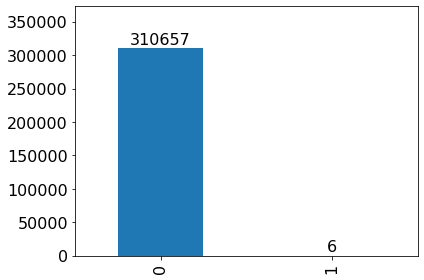

In [11]:
#checking columns that have very few values, e.g. flow_cwr column
ax = df['flow_cwr'].value_counts().plot(kind='bar',fontsize=16) 
for p in ax.patches:
    x = p.get_x()
    h = p.get_height()
    w = p.get_width()
    ax.annotate(f'{h:.0f}\n', (x + w/2, h), ha='center', va='center', size=16)
plt.margins(y=0.2)
plt.tight_layout()
plt.show()

In [12]:
#delete flow_cwr column
df.drop('flow_cwr',axis=1,inplace=True)

In [14]:
#counting classes
collections.Counter(df.label.values)

Counter({0: 292386, 1: 18277})

In [15]:
#Delete Rows That Contain Duplicate Data
print(df.shape)
df.drop_duplicates(inplace=True)
print(df.shape)

(310663, 44)
(307754, 44)


In [16]:
#counting classes
collections.Counter(df.label.values)

Counter({0: 289490, 1: 18264})

In [17]:
df

,proto,srcPrt,dstPrt,flowduration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,...,mean_flowpktl,std_flowpktl,mean_flowipt,std_flowipt,flow_fin,flow_syn,flow_rst,flow_ack,downUpRatio,label
0,TCP,41039,25,0.000012,1,1,62,54,62,54,...,58.000000,5.656854,0.000012,0.000000,0,1,1,1,0.870968,0
1,TCP,41040,25,0.000012,1,1,62,54,62,54,...,58.000000,5.656854,0.000012,0.000000,0,1,1,1,0.870968,0
2,TCP,60720,80,0.000021,1,1,60,54,60,54,...,57.000000,4.242640,0.000021,0.000000,1,0,0,2,0.900000,0
3,TCP,60731,80,55.912911,21,35,1632,43821,60,54,...,811.660714,679.490845,1.101565,6.891815,2,2,0,55,26.851103,0
4,TCP,48889,80,12.624237,5,5,788,735,66,66,...,152.300000,177.225571,2.737010,5.315071,2,2,0,9,0.932741,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
310658,UDP,58665,53,0.259362,1,1,73,382,73,382,...,227.500000,218.496002,0.259362,0.000000,0,0,0,0,5.232877,0
310659,UDP,47777,53,0.076347,1,1,84,324,84,324,...,204.000000,169.705627,0.076347,0.000000,0,0,0,0,3.857143,0
310660,UDP,62559,53,0.000184,1,1,84,143,84,143,...,113.500000,41.719299,0.000184,0.000000,0,0,0,0,1.702381,0
310661,UDP,47777,53,0.107837,1,1,100,129,100,129,...,114.500000,20.506096,0.107837,0.000000,0,0,0,0,1.290000,0


In [18]:
#check % class distribution 
y=df['label'].values #convert to nparray

classes=np.unique(y)
total=len(y)

for c in classes:
    n_examples=len(y[y==c])
    percent = n_examples/total*100
    print('> Class %d : %d of %d (%.1f%%)' % (c, n_examples,total,percent))

> Class 0 : 289490 of 307754 (94.1%)
> Class 1 : 18264 of 307754 (5.9%)


# Coding of categorical variables
[Target encoding](https://contrib.scikit-learn.org/category_encoders/targetencoder.html) for categorical features will be used to encode three nominal categorical variables: protocol, source and destination ports. This method is supervised and requires training.

In [19]:
#check data types for each feature
df.dtypes

proto                  object
srcPrt                  int64
dstPrt                  int64
flowduration          float64
total_fpackets          int64
total_bpackets          int64
total_fpktl             int64
total_bpktl             int64
min_fpktl               int64
min_bpktl               int64
max_fpktl               int64
max_bpktl               int64
mean_fpktl            float64
mean_bpktl            float64
std_fpktl             float64
std_bpktl             float64
total_fipt            float64
total_bipt            float64
min_fipt              float64
min_bipt              float64
max_fipt              float64
max_bipt              float64
mean_fipt             float64
mean_bipt             float64
std_fipt              float64
std_bipt              float64
fpsh_cnt                int64
bpsh_cnt                int64
total_fhlen             int64
total_bhlen             int64
fPktsPerSecond        float64
bPktsPerSecond        float64
flowPktsPerSecond     float64
flowBytesP

In [22]:
#create training and test dataset
X_train,X_test,y_train,y_test = train_test_split(df.drop(columns=['label']), df['label'], test_size=0.2, random_state=42)

In [23]:
#load library for target encoder 
from category_encoders import TargetEncoder

In [24]:
# Selecting the three categorical variables to be coded
enc = TargetEncoder(cols=['proto','srcPrt','dstPrt'])

# transform the datasets
training_numeric_dataset = enc.fit_transform(X_train, y_train)
testing_numeric_dataset = enc.transform(X_test)

In [26]:
#show the coded features
testing_numeric_dataset

,proto,srcPrt,dstPrt,flowduration,total_fpackets,total_bpackets,total_fpktl,total_bpktl,min_fpktl,min_bpktl,...,flowBytesPerSecond,mean_flowpktl,std_flowpktl,mean_flowipt,std_flowipt,flow_fin,flow_syn,flow_rst,flow_ack,downUpRatio
156306,0.025356,5.929254e-02,0.025093,0.000105,1,1,106,54,106,54,...,1.525202e+06,80.000000,36.769554,0.000105,0.000000,0,0,0,0,0.509434
190053,0.025356,9.968726e-01,0.025093,60.318130,8,4,568,1544,66,342,...,3.501435e+01,176.000000,157.611145,5.516488,17.837491,0,0,0,0,2.718310
239389,0.025356,3.643037e-07,0.025093,2.132073,1,1,85,149,85,149,...,1.097523e+02,117.000000,45.254833,2.132073,0.000000,0,0,0,0,1.752941
65943,0.167577,9.902696e-07,0.021653,80.740670,13,24,1130,21826,60,54,...,2.843177e+02,620.432432,673.613342,4.393708,14.396949,7,2,1,35,19.315044
155587,0.025356,5.401853e-05,0.025093,0.000475,1,1,81,360,81,360,...,9.285582e+05,220.500000,197.282791,0.000475,0.000000,0,0,0,0,4.444445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49948,0.167577,9.030241e-10,0.021653,9.454764,32,47,2564,61705,66,66,...,6.797525e+03,813.531646,678.766235,0.123546,0.453059,2,2,0,78,24.065912
205339,0.025356,5.929254e-02,0.025093,0.000157,1,1,88,139,88,139,...,1.444775e+06,113.500000,36.062447,0.000157,0.000000,0,0,0,0,1.579545
188501,0.025356,1.594622e-02,0.025093,0.358496,1,1,74,74,74,74,...,4.128359e+02,74.000000,0.000000,0.358496,0.000000,0,0,0,0,1.000000
299192,0.025356,0.000000e+00,0.025093,0.191670,1,1,90,223,90,223,...,1.633014e+03,156.500000,94.045204,0.191670,0.000000,0,0,0,0,2.477778


# Standardization and scaling of numerical variables

In [28]:
# import libraries
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

numeric_cols = training_numeric_dataset.select_dtypes(include=['float64', 'int']).columns.to_list()
preprocessor = ColumnTransformer([('scale', StandardScaler(), numeric_cols)], remainder='passthrough')

In [29]:
X_train_prep = preprocessor.fit_transform(training_numeric_dataset)
X_test_prep  = preprocessor.transform(testing_numeric_dataset)
#The result returned by ColumnTransformer is a numpy array, so the column names are lost.

In [30]:
#Dimensions of training and testing datasets
X_train_prep.shape, X_test_prep.shape

((246203, 43), (61551, 43))

# Feature selection
Exclusion of variables with variance close to zero

In [31]:
#join the prepared traing and test datasets in a single array X and y
X = np.vstack((X_train_prep, X_test_prep))
y = np.hstack((y_train, y_test))

In [32]:
collections.Counter(y)

Counter({0: 289490, 1: 18264})

>Threshold=0.00, Features=43
>Threshold=0.05, Features=43
>Threshold=0.10, Features=43
>Threshold=0.15, Features=43
>Threshold=0.20, Features=43
>Threshold=0.25, Features=43
>Threshold=0.30, Features=42
>Threshold=0.35, Features=42
>Threshold=0.40, Features=42
>Threshold=0.45, Features=42
>Threshold=0.50, Features=42
>Threshold=0.55, Features=42
>Threshold=0.60, Features=41
>Threshold=0.65, Features=41


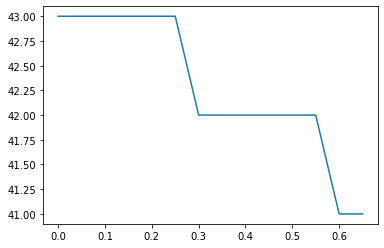

In [33]:
#the VarianceThreshold class from sklearn support a type of feature selection
from sklearn.feature_selection import VarianceThreshold
from numpy import arange
#split data into inputs
#data=df_float.values
#X=data[:,:]
#define thresholds to check
thresholds = arange(0.0,0.7,0.05)
#apply transform with each treshold
results=list()
for t in thresholds:
    #define the transform
    transform = VarianceThreshold(threshold=t)
    #transform the input data
    X_sel=transform.fit_transform(X)
    #determine the number of input features
    n_features=X_sel.shape[1]
    print('>Threshold=%.2f, Features=%d' %(t,n_features))
    #store the result
    results.append(n_features)
#plot the theshold vs the number of selected features
plt.plot(thresholds,results)
plt.show()

In [34]:
#new set of selected features
X=X_sel
print(X.shape)

(307754, 41)


# Create Machine Learning Models

### a) Grid search with Logistic Regression (GS-LR)

In [35]:
# grid search class weights with logistic regression for imbalanced classification

model = LogisticRegression(solver='lbfgs',max_iter=1000)
# define grid
balance = [{0:0.001,1:1.0},{0:0.01,1:1.0}, {0:0.1,1:1}, {0:1,1:100},{0:1,1:200}]
param_grid = dict(class_weight=balance)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv,
scoring='roc_auc')
# execute the grid search
grid_result = grid.fit(X, y)
# report the best configuration
print('Best: %f using %s' % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('%f (%f) with: %r' % (mean, stdev, param))

Best: 0.993922 using {'class_weight': {0: 1, 1: 200}}
0.992426 (0.000864) with: {'class_weight': {0: 0.001, 1: 1.0}}
0.992729 (0.001480) with: {'class_weight': {0: 0.01, 1: 1.0}}
0.979233 (0.031533) with: {'class_weight': {0: 0.1, 1: 1}}
0.992756 (0.001644) with: {'class_weight': {0: 1, 1: 100}}
0.993922 (0.001577) with: {'class_weight': {0: 1, 1: 200}}


C:\Users\pvelarde\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [30]:
## split into train test sets
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
#Using the obtained weights for training the model GS-LR
weights = {0: 0.01, 1: 1.0}
model = LogisticRegression(solver='lbfgs', class_weight=weights,max_iter=2000)
model.fit(X_train, y_train)
y_pred=model.predict(X_test)

C:\Users\pvelarde\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


ROCAUC score: 0.9653222764903033
Accuracy score: 0.940082208250069
F1 score: 0.6615892824371445
Recall score: 0.9939343810311553
Precision score: 0.4958052537477651
              precision    recall  f1-score   support

     class 0       1.00      0.94      0.97     57924
     class 1       0.50      0.99      0.66      3627

    accuracy                           0.94     61551
   macro avg       0.75      0.97      0.81     61551
weighted avg       0.97      0.94      0.95     61551



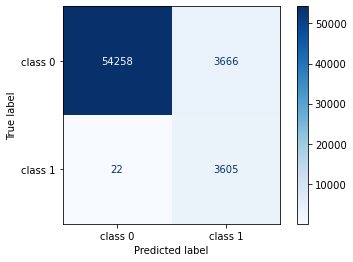

In [32]:
print('ROCAUC score:',roc_auc_score(y_test, y_pred))
print('Accuracy score:',accuracy_score(y_test, y_pred))
print('F1 score:',f1_score(y_test, y_pred))
print('Recall score:',recall_score(y_test, y_pred))
print('Precision score:',precision_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=target_names))
plot_confusion_matrix(model, X_test, y_test, display_labels=target_names,cmap=plt.cm.Blues);

 ### b) Logistic Regression with Synthetic minority over-sampleing technique (LR+SMOTE)

In [43]:
# load library
from imblearn.over_sampling import SMOTE

smote = SMOTE()

# fit target and predictor variable
X_smote , y_smote = smote.fit_resample(X, y)

print('Origianl dataset shape:', Counter(y))
print('Resample dataset shape:', Counter(y_smote))

Origianl dataset shape: Counter({0: 289490, 1: 18264})
Resample dataset shape: Counter({0: 289490, 1: 289490})


In [44]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_smote, y_smote, test_size =0.20, random_state=42)

In [45]:
model2=LogisticRegression(solver='lbfgs',max_iter=2000)
model2.fit(X_train2, y_train2)
y_pred2=model2.predict(X_test2)

ROCAUC score: 0.9780604621336225
Accuracy score: 0.9780821444609485
F1 score: 0.9783922763881557
Recall score: 0.9907409003913995
Precision score: 0.9663476900825752
              precision    recall  f1-score   support

     class 0       0.99      0.97      0.98     57799
     class 1       0.97      0.99      0.98     57997

    accuracy                           0.98    115796
   macro avg       0.98      0.98      0.98    115796
weighted avg       0.98      0.98      0.98    115796



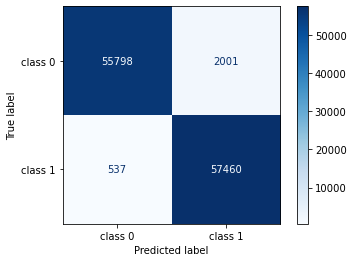

In [46]:
print('ROCAUC score:',roc_auc_score(y_test2, y_pred2))
print('Accuracy score:',accuracy_score(y_test2, y_pred2))
print('F1 score:',f1_score(y_test2, y_pred2))
print('Recall score:',recall_score(y_test2, y_pred2))
print('Precision score:',precision_score(y_test2, y_pred2))

print(classification_report(y_test2, y_pred2, target_names=target_names))
plot_confusion_matrix(model2, X_test2, y_test2, display_labels=target_names,cmap=plt.cm.Blues); 

### c) Weighted Support Vector Machine (W-SVM)


In [48]:
#train a model using Penalized-SVM on the original imbalanced dataset:
#https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/
# we can add class_weight='balanced' to add panalize mistake
model_SVM = SVC(class_weight='balanced', probability=True)
model_SVM.fit(X_train, y_train)
y_pred_SVM = model_SVM.predict(X_test)

In [49]:
y_pred_SVM = model_SVM.predict(X_test)

ROCAUC score: 0.5333173159387599
Accuracy score: 0.12771522802229046
F1 score: 0.11830393799060662
Recall score: 0.9931072511717673
Precision score: 0.06289835332739623
              precision    recall  f1-score   support

     class 0       0.99      0.07      0.14     57924
     class 1       0.06      0.99      0.12      3627

    accuracy                           0.13     61551
   macro avg       0.53      0.53      0.13     61551
weighted avg       0.94      0.13      0.14     61551



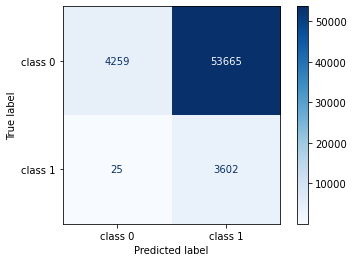

In [50]:
print('ROCAUC score:',roc_auc_score(y_test, y_pred_SVM))
print('Accuracy score:',accuracy_score(y_test, y_pred_SVM))
print('F1 score:',f1_score(y_test, y_pred_SVM))
print('Recall score:',recall_score(y_test, y_pred_SVM))
print('Precision score:',precision_score(y_test, y_pred_SVM))

print(classification_report(y_test, y_pred_SVM, target_names=target_names))
plot_confusion_matrix(model_SVM, X_test, y_test, display_labels=target_names,cmap=plt.cm.Blues);

# Undersampling using CNN
Condensed Nearest Neighbor (CNN) is used to remove redundant examples from the interior of the density of the majority class. 

In [51]:
# undersample an imbalanced dataset with the Condensed Nearest Neighbor Rule pp.148
from imblearn.under_sampling import CondensedNearestNeighbour

In [52]:
counter = Counter(y)
print(counter)

Counter({0: 289490, 1: 18264})


In [53]:
# define the undersampling method
undersample = CondensedNearestNeighbour(n_neighbors=1)
# transform the dataset
Xu, yu = undersample.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(yu)
print(counter)

Counter({1: 18264, 0: 1759})


### d) Weighted Decision Tree with Condensed Nearest Neighbor (DT+CNN)
The `DecisionTreeClassifier` class provides the class weight argument that can be speci ed as a model hyperparameter. The class weight is a dictionary that de nes each class label (e.g. 0 and 1) and the weighting to apply in the calculation of group purity for splits in the decision tree when tting the model.

In [54]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(Xu, yu, test_size =0.20, random_state=42)

In [55]:
# define model
model_DT = DecisionTreeClassifier(class_weight='balanced')
#model performance
model_DT.fit(X_train3, y_train3)
y_pred_DT=model_DT.predict(X_test3)

ROCAUC score: 0.9903243144865687
Accuracy score: 0.9980024968789014
F1 score: 0.9989154013015185
Recall score: 0.9994574064026045
Precision score: 0.9983739837398374
              precision    recall  f1-score   support

     class 0       0.99      0.98      0.99       319
     class 1       1.00      1.00      1.00      3686

    accuracy                           1.00      4005
   macro avg       1.00      0.99      0.99      4005
weighted avg       1.00      1.00      1.00      4005



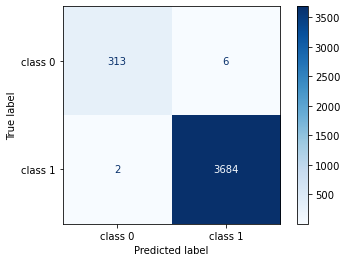

In [56]:
print('ROCAUC score:',roc_auc_score(y_test3, y_pred_DT))
print('Accuracy score:',accuracy_score(y_test3, y_pred_DT))
print('F1 score:',f1_score(y_test3, y_pred_DT))
print('Recall score:',recall_score(y_test3, y_pred_DT))
print('Precision score:',precision_score(y_test3, y_pred_DT))

print(classification_report(y_test3, y_pred_DT, target_names=target_names))
plot_confusion_matrix(model_DT, X_test3, y_test3, display_labels=target_names,cmap=plt.cm.Blues);

### e) Support Vector Machine with Condensed Nearest Neighbor (SVM+CNN)

In [59]:
model_SVM_cnn = SVC(class_weight='balanced', probability=True)
model_SVM_cnn.fit(X_train3, y_train3)
y_pred_SVM_cnn = model_SVM_cnn.predict(X_test3)

ROCAUC score: 0.7372320412575245
Accuracy score: 0.8826466916354557
F1 score: 0.9345403899721448
Recall score: 0.9102007596310363
Precision score: 0.9602175157412708
              precision    recall  f1-score   support

     class 0       0.35      0.56      0.43       319
     class 1       0.96      0.91      0.93      3686

    accuracy                           0.88      4005
   macro avg       0.66      0.74      0.68      4005
weighted avg       0.91      0.88      0.89      4005



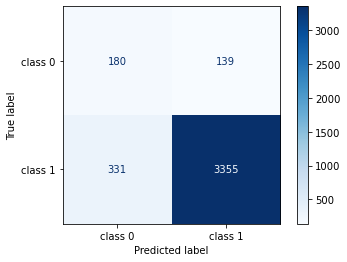

In [60]:
print('ROCAUC score:',roc_auc_score(y_test3, y_pred_SVM_cnn))
print('Accuracy score:',accuracy_score(y_test3, y_pred_SVM_cnn))
print('F1 score:',f1_score(y_test3, y_pred_SVM_cnn))
print('Recall score:',recall_score(y_test3, y_pred_SVM_cnn))
print('Precision score:',precision_score(y_test3, y_pred_SVM_cnn))

print(classification_report(y_test3, y_pred_SVM_cnn, target_names=target_names))
plot_confusion_matrix(model_SVM_cnn, X_test3, y_test3, display_labels=target_names,cmap=plt.cm.Blues);